In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Training - Sub model 1

## Load the Dataset 1

In [2]:
import pandas as pd

ATB_OT = pd.read_csv(r'/content/drive/MyDrive/Research/TB_new/Datasets/train/balanced/ATB_OT.csv')

## Separate features and target

In [3]:
# Separate features and target in each dataset

X_ATB_OT = ATB_OT.drop(columns=['TB_Status'])
y_ATB_OT = ATB_OT['TB_Status']

## Training the model using best algorithm

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle
import os

In [5]:
import numpy as np

selected_features_path = r"/content/drive/MyDrive/Research/TB_new/Saved_files/selected_features_ATB_OT.csv"

# Load selected features
selected_features = pd.read_csv(selected_features_path)
# Assuming the selected features are the columns of the loaded dataframe
selected_feature_names = selected_features.columns.tolist()
X_ATB_OT = X_ATB_OT[selected_feature_names]

# Split data
X_train_TB_Status, X_test_TB_Status, y_train_TB_Status, y_test_TB_Status = train_test_split(
    X_ATB_OT, y_ATB_OT, test_size=0.2, random_state=42, stratify=y_ATB_OT
)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_TB_Status)
y_test_encoded = label_encoder.transform(y_test_TB_Status)

# Define TB status labels
tb_status_labels = ["Active TB", "Inactive",]

print(f"Training set shape: {X_train_TB_Status.shape}")
print(f"Test set shape: {X_test_TB_Status.shape}")
print(f"Class distribution in training: {dict(zip(tb_status_labels, np.bincount(y_train_encoded)))}")

Training set shape: (1454, 5)
Test set shape: (364, 5)
Class distribution in training: {'Active TB': np.int64(727), 'Inactive': np.int64(727)}


In [6]:
# --- Create Optimized SVM Pipeline with Best Hyperparameters ---
model_TB_Status = Pipeline([
    ('scaler', StandardScaler()),  # Feature Scaling (essential for SVM)
    ('svm', SVC(
        C=10,                    # Best from hyperparameter tuning
        gamma='auto',            # Best from hyperparameter tuning
        kernel='rbf',            # Best from hyperparameter tuning
        probability=True,        # Enable probability predictions
        random_state=42,
        cache_size=1000,         # Increase cache for faster training
        decision_function_shape='ovr'  # One-vs-rest for multi-class
    ))
])

# --- Train the Model ---
print("Training SVM model with optimal hyperparameters...")
model_TB_Status.fit(X_train_TB_Status, y_train_encoded)

# --- Evaluate on Test Set ---
y_pred_best_TB_Status = model_TB_Status.predict(X_test_TB_Status)
y_pred_proba = model_TB_Status.predict_proba(X_test_TB_Status)

print("\n" + "="*60)
print("SUB-MODEL 1 (TB_HC_OD) - OPTIMIZED SVM PERFORMANCE")
print("="*60)

# Detailed classification report
print("\nBest TB_Status Classification Report:")
print(classification_report(y_test_encoded, y_pred_best_TB_Status, target_names=tb_status_labels))

# Individual metrics
accuracy = accuracy_score(y_test_encoded, y_pred_best_TB_Status)
precision = precision_score(y_test_encoded, y_pred_best_TB_Status, average='weighted')
recall = recall_score(y_test_encoded, y_pred_best_TB_Status, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_best_TB_Status, average='weighted')

print(f"\nOverall Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Class-wise performance
print(f"\nClass-wise Performance:")
for i, label in enumerate(tb_status_labels):
    class_precision = precision_score(y_test_encoded, y_pred_best_TB_Status, average=None)[i]
    class_recall = recall_score(y_test_encoded, y_pred_best_TB_Status, average=None)[i]
    class_f1 = f1_score(y_test_encoded, y_pred_best_TB_Status, average=None)[i]
    print(f"{label:15} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1: {class_f1:.4f}")

# --- Save the Trained Model ---
model_save_path = r"/content/drive/MyDrive/Research/TB_new/Saved_files/best_sub_model_1.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(model_TB_Status, file)

print(f"\n✅ Trained model saved to {model_save_path}")


Training SVM model with optimal hyperparameters...

SUB-MODEL 1 (TB_HC_OD) - OPTIMIZED SVM PERFORMANCE

Best TB_Status Classification Report:
              precision    recall  f1-score   support

   Active TB       0.78      0.73      0.75       182
    Inactive       0.74      0.79      0.77       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364


Overall Metrics:
Accuracy:  0.7582
Precision: 0.7594
Recall:    0.7582
F1-Score:  0.7580

Class-wise Performance:
Active TB       - Precision: 0.7765, Recall: 0.7253, F1: 0.7500
Inactive        - Precision: 0.7423, Recall: 0.7912, F1: 0.7660

✅ Trained model saved to /content/drive/MyDrive/Research/TB_new/Saved_files/best_sub_model_1.pkl


In [9]:
# Extract the scaler from the pipeline
scaler_TB_Status = model_TB_Status.named_steps['scaler']

# Define paths to save the scaler
scaler_save_path_TB_Status = r"/content/drive/MyDrive/Research/TB_new/Saved_files/scalar/scaler_TB_Status.pkl"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(scaler_save_path_TB_Status), exist_ok=True)


# Save the scaler
with open(scaler_save_path_TB_Status, 'wb') as file:
    pickle.dump(scaler_TB_Status, file)

print(f"Scaler for TB Status saved to {scaler_save_path_TB_Status}")

Scaler for TB Status saved to /content/drive/MyDrive/Research/TB_new/Saved_files/scalar/scaler_TB_Status.pkl


## Evaluation of the sub model

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and display metrics
def evaluate_model(y_true, y_pred, label):
    print(f"\n--- Evaluation Metrics for {label} ---")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


--- Model Evaluation ---

--- Evaluation Metrics for TB_Status ---
Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1 Score: 0.76




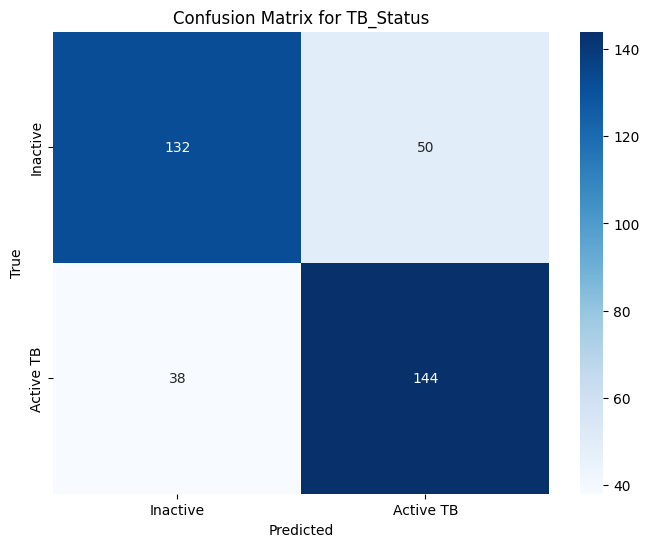

In [11]:
# Evaluate models using test datasets
print("\n--- Model Evaluation ---")
# TB_Status Evaluation using the best model
y_pred_TB_Status = model_TB_Status.predict(X_test_TB_Status)

# Convert encoded predictions back to text labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_TB_Status)

# Evaluate using original labels
evaluate_model(y_test_labels, y_pred_labels, "TB_Status")

